In [ ]:
%%capture
!pip install unsloth
# Also get the latest nightly Unsloth!
!pip uninstall unsloth -y && pip install --upgrade --no-cache-dir --no-deps git+https://github.com/unslothai/unsloth.git

In [ ]:
from unsloth import FastVisionModel # FastLanguageModel for LLMs
import torch

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
# fourbit_models = [
#     "unsloth/Llama-3.2-11B-Vision-Instruct-bnb-4bit", # Llama 3.2 vision support
#     "unsloth/Llama-3.2-11B-Vision-bnb-4bit",
#     "unsloth/Llama-3.2-90B-Vision-Instruct-bnb-4bit", # Can fit in a 80GB card!
#     "unsloth/Llama-3.2-90B-Vision-bnb-4bit",

#     "unsloth/Pixtral-12B-2409-bnb-4bit",              # Pixtral fits in 16GB!
#     "unsloth/Pixtral-12B-Base-2409-bnb-4bit",         # Pixtral base model

#     "unsloth/Qwen2-VL-2B-Instruct-bnb-4bit",          # Qwen2 VL support
#     "unsloth/Qwen2-VL-7B-Instruct-bnb-4bit",
#     "unsloth/Qwen2-VL-72B-Instruct-bnb-4bit",

#     "unsloth/llava-v1.6-mistral-7b-hf-bnb-4bit",      # Any Llava variant works!
#     "unsloth/llava-1.5-7b-hf-bnb-4bit",
# ] # More models at https://huggingface.co/unsloth

model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/Llama-3.2-11B-Vision-Instruct",
    load_in_4bit = False, # Use 4bit to reduce memory use. False for 16bit LoRA.
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for long context
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.2.12: Fast Mllama vision patching. Transformers: 4.48.3.
   \\   /|    GPU: NVIDIA A100-SXM4-40GB. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.0. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors.index.json:   0%|          | 0.00/89.4k [00:00<?, ?B/s]

model-00001-of-00005.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00005.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00003-of-00005.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00005.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00005-of-00005.safetensors:   0%|          | 0.00/1.47G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/210 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/477 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/55.9k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/5.15k [00:00<?, ?B/s]

In [ ]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers     = False, # False if not finetuning vision layers
    finetune_language_layers   = True, # False if not finetuning language layers
    finetune_attention_modules = True, # False if not finetuning attention layers
    finetune_mlp_modules       = True, # False if not finetuning MLP layers

    r = 16,           # The larger, the higher the accuracy, but might overfit
    lora_alpha = 16,  # Recommended alpha == r at least
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
    # target_modules = "all-linear", # Optional now! Can specify a list if needed
)

Unsloth: Making `model.base_model.model.language_model` require gradients


In [ ]:
from datasets import load_dataset
dataset = load_dataset("tukey/human_face_emotions_roboflow", split = "train")

README.md:   0%|          | 0.00/387 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/371M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/9400 [00:00<?, ? examples/s]

In [ ]:
dataset

Dataset({
    features: ['image', 'qa'],
    num_rows: 9400
})

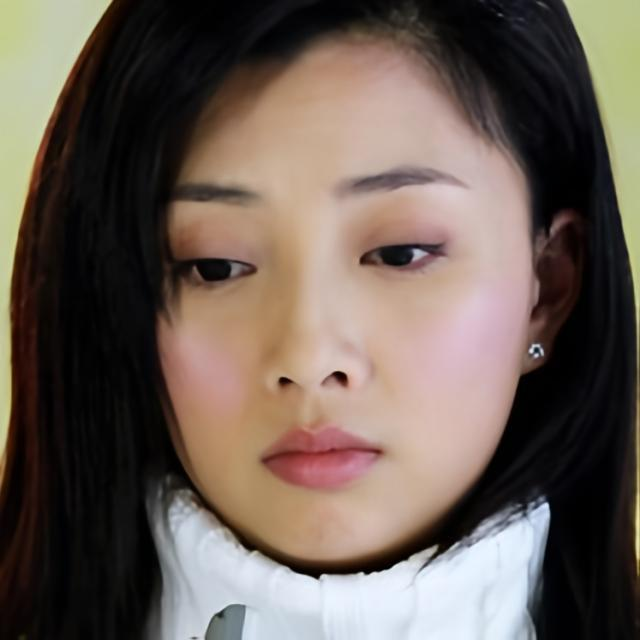

In [ ]:
dataset[0]["image"]

In [ ]:
from datasets import load_dataset

def map_emotion_labels(dataset):
    """
    Maps numeric emotion labels to text labels in a dataset.

    Args:
        dataset: A HuggingFace dataset with numeric emotion labels

    Returns:
        Modified dataset with text emotion labels
    """
    # Define the mapping dictionary
    # emotion_map = {
    #     0: "anger",
    #     1: "contempt",
    #     2: "disgust",
    #     3: "fear",
    #     4: "happy",
    #     5: "neutral",
    #     6: "sad",
    #     7: "surprise"
    # }

    def convert_label(example):
        """Helper function to convert a single example's label"""
        example["emotion"] = example["qa"][0]["answer"]
        return example

    # Apply the mapping to the entire dataset
    mapped_dataset = dataset.map(convert_label)

    return mapped_dataset

# Load and transform the dataset
# dataset = load_dataset("FastJobs/Visual_Emotional_Analysis", split="train")
mapped_dataset = map_emotion_labels(dataset)

# Example usage:
#print(f"Original label: {dataset['qa'][0]['answer']}")
print(f"Mapped emotion: {mapped_dataset[0]['emotion']}")
print(f"Mapped image: {mapped_dataset[0]['image']}")

Map:   0%|          | 0/9400 [00:00<?, ? examples/s]

Mapped emotion: sad
Mapped image: <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x7D0F71CE0310>


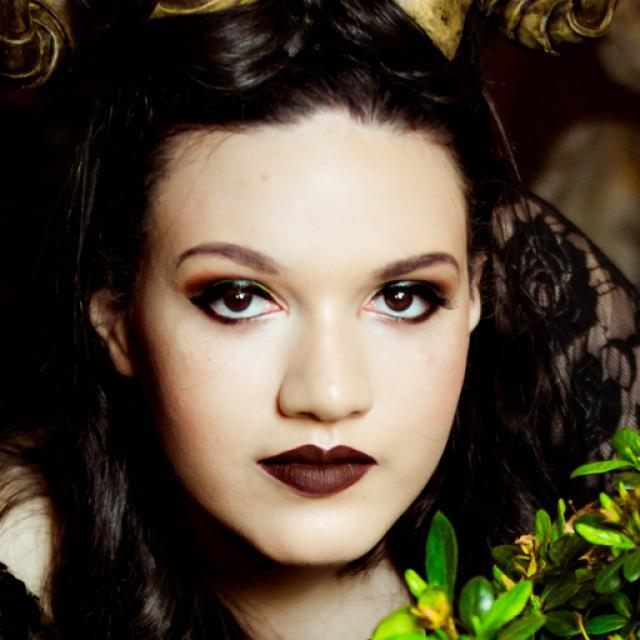

In [ ]:
mapped_dataset[2]["emotion"]
mapped_dataset[2]["image"]

In [ ]:
mapped_dataset[2]["emotion"]

'neutral'

In [ ]:
instruction = "You are an expert therapist. Your role is to recognize the emotion from the photo. Return the recognized emotion in one word."

def convert_to_conversation(sample):
    conversation = [
        { "role": "user",
          "content" : [
            {"type" : "text",  "text"  : instruction},
            {"type" : "image", "image" : sample["image"]} ]
        },
        { "role" : "assistant",
          "content" : [
            {"type" : "text",  "text"  : sample["emotion"]} ]
        },
    ]
    return { "messages" : conversation }
pass

Let's convert the dataset into the "correct" format for finetuning:

In [ ]:
converted_dataset = [convert_to_conversation(sample) for sample in mapped_dataset]

In [ ]:
converted_dataset[0]

{'messages': [{'role': 'user',
   'content': [{'type': 'text',
     'text': 'You are an expert therapist. Your role is to recognize the emotion from the photo. Return the recognized emotion in one word.'},
    {'type': 'image',
     'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640>}]},
  {'role': 'assistant', 'content': [{'type': 'text', 'text': 'sad'}]}]}

In [ ]:
FastVisionModel.for_inference(model) # Enable for inference!

image = mapped_dataset[0]["image"]
instruction = "You are an expert therapist. Your role is to recognize the emotion from the photo. Return the recognized emotion in one word."

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 256,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

Sad.<|eot_id|>


<a name="Train"></a>
### Train the model


In [ ]:
from unsloth import is_bf16_supported
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig

FastVisionModel.for_training(model) # Enable for training!

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    data_collator = UnslothVisionDataCollator(model, tokenizer), # Must use!
    train_dataset = converted_dataset,
    args = SFTConfig(
        per_device_train_batch_size = 16,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        # max_steps = 30,
        num_train_epochs = 1, # Set this instead of max_steps for full training runs
        learning_rate = 2e-4,
        fp16 = not is_bf16_supported(),
        bf16 = is_bf16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none",     # For Weights and Biases

        # You MUST put the below items for vision finetuning:
        remove_unused_columns = False,
        dataset_text_field = "",
        dataset_kwargs = {"skip_prepare_dataset": True},
        dataset_num_proc = 4,
        max_seq_length = 2048,
    ),
)

In [ ]:
#@title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA A100-SXM4-40GB. Max memory = 39.557 GB.
27.562 GB of memory reserved.


In [ ]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 9,400 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 16 | Gradient Accumulation steps = 4
\        /    Total batch size = 64 | Total steps = 147
 "-____-"     Number of trainable parameters = 52,428,800
🦥 Unsloth needs about 1-3 minutes to load everything - please wait!


Step,Training Loss
1,1.898200
2,1.910800
3,1.660600
4,1.288800
5,0.793200
6,0.481800
7,0.379400
8,0.358400
9,0.335800
10,0.337000


In [ ]:
#@title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

3157.0019 seconds used for training.
52.62 minutes used for training.
Peak reserved memory = 36.525 GB.
Peak reserved memory for training = 8.963 GB.
Peak reserved memory % of max memory = 92.335 %.
Peak reserved memory for training % of max memory = 22.658 %.


<a name="Inference"></a>
### Inference
Let's run the model! You can change the instruction and input - leave the output blank!

We use `min_p = 0.1` and `temperature = 1.5`. Read this [Tweet](https://x.com/menhguin/status/1826132708508213629) for more information on why.

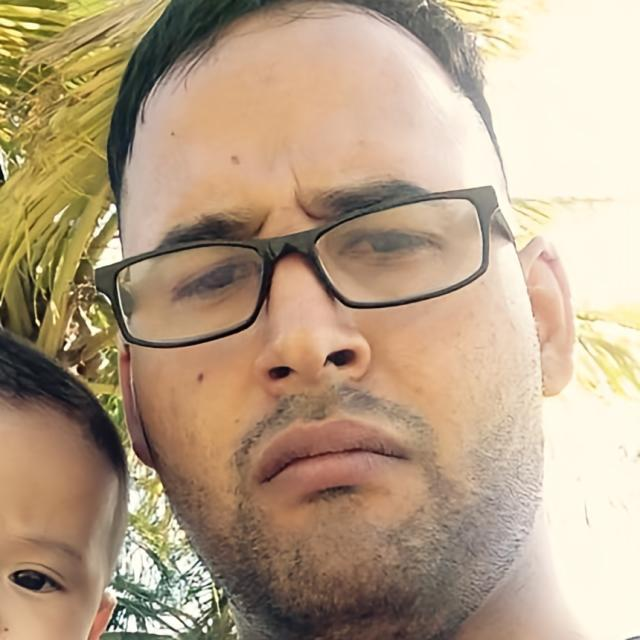

In [ ]:
mapped_dataset[1]["emotion"]
mapped_dataset[1]["image"]

In [ ]:
mapped_dataset[2]["emotion"]


'neutral'

In [ ]:
FastVisionModel.for_inference(model) # Enable for inference!

image = mapped_dataset[20]["image"]
instruction = "You are an expert therapist. Your role is to recognize the emotion from the photo. Return the recognized emotion in one word."

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 0.1, min_p = 0.1)

disgust<|eot_id|>


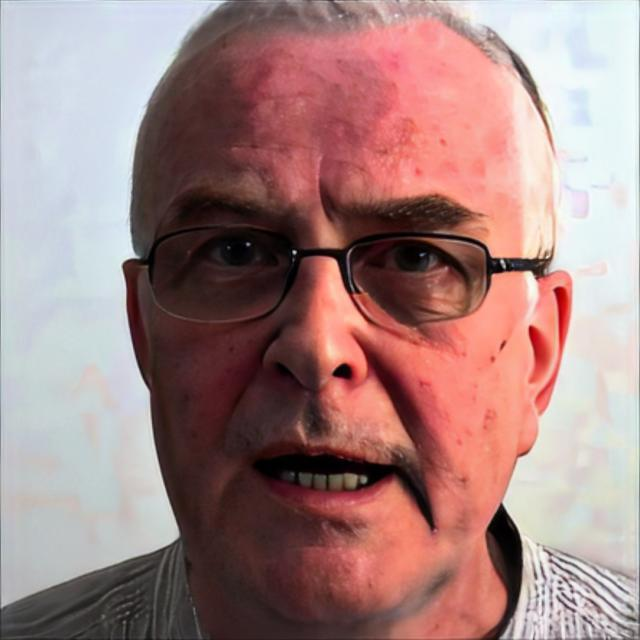

In [ ]:
mapped_dataset[20]["image"]

<a name="Save"></a>
### Saving, loading finetuned models


In [ ]:
model.save_pretrained("lora_model") # Local saving
tokenizer.save_pretrained("lora_model")
# model.push_to_hub("your_name/lora_model", token = "...") # Online saving
# tokenizer.push_to_hub("your_name/lora_model", token = "...") # Online saving

[]

In [ ]:
if False:
    from unsloth import FastVisionModel
    model, tokenizer = FastVisionModel.from_pretrained(
        model_name = "lora_model", # YOUR MODEL YOU USED FOR TRAINING
        load_in_4bit = True, # Set to False for 16bit LoRA
    )
    FastVisionModel.for_inference(model) # Enable for inference!

image = dataset[0]["image"]
instruction = "You are an expert radiographer. Describe accurately what you see in this image."

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

The panoramic radiograph shows bilateral hypoplasia of the condylar heads and mandibular fossae in a patient with fibrodysplasia ossificans progressiva.<|eot_id|>


In [ ]:
# Select ONLY 1 to save! (Both not needed!)

# Save locally to 16bit
# if False: model.save_pretrained_merged("unsloth_finetune", tokenizer,)

# To export and save to your Hugging Face account
model.push_to_hub_merged("seasalt29/imageModelBig", tokenizer, token = "huggingface token here")

  0%|          | 0/1 [00:00<?, ?it/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

Unsloth: Merging weights into 16bit: 100%|██████████| 5/5 [02:29<00:00, 29.94s/it]


  0%|          | 0/5 [00:00<?, ?it/s]

model-00001-of-00005.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00005.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00003-of-00005.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00005.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00005-of-00005.safetensors:   0%|          | 0.00/1.47G [00:00<?, ?B/s]

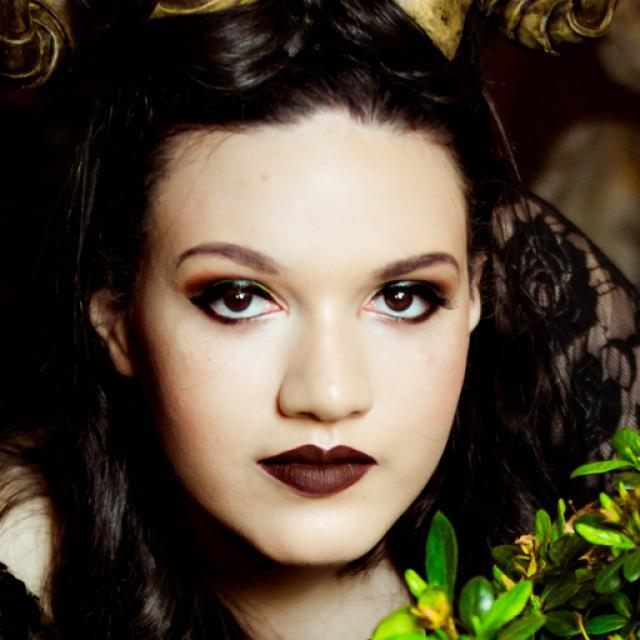

In [ ]:
mapped_dataset[2]["image"]